# CDMS Match Up Demo
Cloud-based Data Matchup Service (CDMS) allows users to collocate satellite to in situ and satellite to satellite data. 

In this notebook, the in situ data subsetting and match-up features will be demonstrated.

In [1]:
import requests
import json
import pandas as pd
import geopandas as gpd
from urllib.parse import urljoin, urlencode
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

import cdms_reader

### List available satellite and in situ datasets

In [2]:
response = requests.get("https://doms.jpl.nasa.gov/list").json()
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(response)[['title', 'iso_start', 'iso_end']]
df.sort_values('title')

,title,iso_start,iso_end
0,ASCATB-L2-Coastal,2015-06-30T23:51:00+0000,2019-01-01T00:02:58+0000
1,AVHRR_OI_L4_GHRSST_NCEI,2015-11-01T00:00:00+0000,2015-11-30T00:00:00+0000
2,JPL-L4-MRVA-CHLA-GLOB-v3.0,2017-01-01T12:00:00+0000,2018-12-31T12:00:00+0000
3,MUR25-JPL-L4-GLOB-v04.2,2017-01-01T09:00:00+0000,2018-12-31T09:00:00+0000
4,OISSS_L4_multimission_7day_v1,2016-12-31T00:00:00+0000,2019-01-02T00:00:00+0000
5,SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812,1992-10-02T12:00:00+0000,2019-01-24T12:00:00+0000
6,SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5,2016-12-28T12:00:00+0000,2019-01-04T12:00:00+0000
7,VIIRS_NPP-JPL-L2P-v2016.2,2017-01-06T05:12:01+0000,2018-12-27T23:36:01+0000
8,VIIRS_NPP-JPL-L2P-v2016.2-TEST,2017-01-01T00:00:01+0000,2017-01-01T00:00:01+0000


In [3]:
in_situ_list = []
# manually add in situ metadata to list 
in_situ_list.append({"title": "ICOADS Release 3.0", "iso_start": "2017-01-01T00:00:00+0000","iso_end": "2018-12-31T23:59:59+0000"})
in_situ_list.append({"title": "SAMOS", "iso_start": "2017-01-01T00:00:00+0000","iso_end": "2018-12-31T23:59:59+0000"})
in_situ_list.append({"title": "1021_atlantic", "iso_start": "2019-01-30T01:00:00+0000","iso_end": "2019-10-16T16:00:00+0000"})
in_situ_list.append({"title": "antarctic_circumnavigation_2019", "iso_start": "2019-01-19T00:00:00+0000","iso_end": "2020-08-15T00:00:00+0000"})
in_situ_list.append({"title": "atlantic_to_med_2019_to_2020", "iso_start": "2019-10-18T10:12:00+0000","iso_end": "2020-07-17T13:45:00+0000"})
in_situ_list.append({"title": "shark-2018", "iso_start": "2018-03-15T20:00:00+0000","iso_end": "2018-06-17T00:00:00+0000"})
in_situ_list.append({"title": "SPURS", "iso_start": "2011-10-19T19:09:00+0000","iso_end": "2019-03-11T23:42:00+0000"})

insitu_df = pd.DataFrame(in_situ_list)[['title', 'iso_start', 'iso_end']]
insitu_df

,title,iso_start,iso_end
0,ICOADS Release 3.0,2017-01-01T00:00:00+0000,2018-12-31T23:59:59+0000
1,SAMOS,2017-01-01T00:00:00+0000,2018-12-31T23:59:59+0000
2,1021_atlantic,2019-01-30T01:00:00+0000,2019-10-16T16:00:00+0000
3,antarctic_circumnavigation_2019,2019-01-19T00:00:00+0000,2020-08-15T00:00:00+0000
4,atlantic_to_med_2019_to_2020,2019-10-18T10:12:00+0000,2020-07-17T13:45:00+0000
5,shark-2018,2018-03-15T20:00:00+0000,2018-06-17T00:00:00+0000
6,SPURS,2011-10-19T19:09:00+0000,2019-03-11T23:42:00+0000


### Subset in situ dataset and plot

In [4]:
query_params = {
    'provider': 'Saildrone',
    'project': 'shark-2018',
    'startTime': '2018-04-01T00:00:00Z',
    'endTime': '2018-04-07T23:59:59Z',
    'bbox': '-180,-90,180,90',
    'platform': '3B',
    'minDepth': -5,
    'maxDepth': 5,
    'variable': 'mass_concentration_of_chlorophyll_in_sea_water',
    'columns': 'mass_concentration_of_chlorophyll_in_sea_water',
    'startIndex': 0,
    'itemsPerPage': 15000
}

In [5]:
in_situ_url = 'https://nasa-cdms.saildrone.com/1.0/query_data_doms_custom_pagination'
full_in_situ_url = f'{in_situ_url}?{urlencode(query_params)}'
print(full_in_situ_url)
response = requests.get(full_in_situ_url).json()
print(f'Total number of points returned {response["total"]}')
insitu_df = pd.DataFrame(response["results"])
insitu_df.head() # show first few records

https://nasa-cdms.saildrone.com/1.0/query_data_doms_custom_pagination?provider=Saildrone&project=shark-2018&startTime=2018-04-01T00%3A00%3A00Z&endTime=2018-04-07T23%3A59%3A59Z&bbox=-180%2C-90%2C180%2C90&platform=3B&minDepth=-5&maxDepth=5&variable=mass_concentration_of_chlorophyll_in_sea_water&columns=mass_concentration_of_chlorophyll_in_sea_water&startIndex=0&itemsPerPage=15000
Total number of points returned 10052


,mass_concentration_of_chlorophyll_in_sea_water,time,depth,latitude,longitude,platform,provider,project,meta
0,0.09,2018-04-01T00:00:00Z,0.5,27.240928,-130.020352,"{'type': 'saildrone', 'code': '3B', 'id': '1001'}",Saildrone,shark-2018,None
1,0.09,2018-04-01T00:01:00Z,0.5,27.240611,-130.020339,"{'type': 'saildrone', 'code': '3B', 'id': '1001'}",Saildrone,shark-2018,None
2,0.09,2018-04-01T00:02:00Z,0.5,27.240314,-130.020326,"{'type': 'saildrone', 'code': '3B', 'id': '1001'}",Saildrone,shark-2018,None
3,0.09,2018-04-01T00:03:00Z,0.5,27.240077,-130.020326,"{'type': 'saildrone', 'code': '3B', 'id': '1001'}",Saildrone,shark-2018,None
4,0.10,2018-04-01T00:04:00Z,0.5,27.239830,-130.020301,"{'type': 'saildrone', 'code': '3B', 'id': '1001'}",Saildrone,shark-2018,None


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

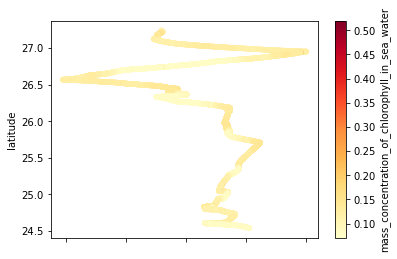

In [6]:
# Simple plot of data
insitu_df.plot(x='longitude', y='latitude', kind='scatter', c='mass_concentration_of_chlorophyll_in_sea_water', colormap='YlOrRd')


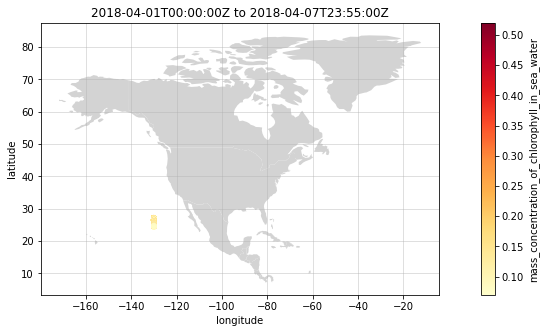

In [7]:
# Plot with a map 

# initialize an axis
fig, ax = plt.subplots(figsize=(15,5))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#print(countries)
countries[countries['continent'] == 'North America'].plot(color='lightgrey', ax=ax)

# parse dates for plot's title
first = insitu_df['time'].min()
last = insitu_df['time'].max()

# plot points
insitu_df.plot(x='longitude', y='latitude', kind='scatter', 
        c='mass_concentration_of_chlorophyll_in_sea_water', colormap='YlOrRd', 
        title=f'{first} to {last}', 
        ax=ax)

# add grid
ax.grid(alpha=0.5)
plt.show()


### Run satellite to in situ matchup query
Match JPL-L4-MRVA-CHLA-GLOB-v3.0 with Saildrone White Shark Café

In [8]:
matchup_url = 'https://doms.jpl.nasa.gov/match_spark'

In [9]:
def execute_matchup_request(query_params, in_situ_variable_name=None):
    full_matchup_url = f'{matchup_url}?{urlencode(query_params)}'
    print(full_matchup_url)
    
    response = requests.get(full_matchup_url)
    response = response.json()
    
    primary_points = []
    secondary_points = []
    for primary_point in response['data']:
        for variable in primary_point['matches'][0]['secondary']:
            if in_situ_variable_name:
                if variable['variable_name'] == in_situ_variable_name:
                    primary_points.append((float(primary_point['lon']), float(primary_point['lat']), float(primary_point['primary'][0]['variable_value'])))
                    secondary_points.append((float(primary_point['matches'][0]['lon']), float(primary_point['matches'][0]['lat']), float(variable['variable_value'])))
            else:
                # pick the first variable
                primary_points.append((float(primary_point['lon']), float(primary_point['lat']), float(primary_point['primary'][0]['variable_value'])))
                secondary_points.append((float(primary_point['matches'][0]['lon']), float(primary_point['matches'][0]['lat']), float(variable['variable_value'])))
                break
    print(f'Total number of primary matched points {len(primary_points)}')
    print(f'Total number of secondary matched points {len(secondary_points)}')
    return primary_points, secondary_points, response['executionId']

In [10]:
query_params = {
    'primary': 'JPL-L4-MRVA-CHLA-GLOB-v3.0',
    'secondary': 'shark-2018',
    'startTime': '2018-04-01T00:00:00Z',
    'endTime': '2018-04-01T23:59:59Z',
    'tt': 86400,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-140,10,-110,40',
    'platforms': '3B',
    'parameter': 'mass_concentration_of_chlorophyll_in_sea_water',
    'depthMin': -5,
    'depthMax': 5,
    'matchOnce': 'true',
    'resultSizeLimit': 100
}

In [11]:
primary_points, secondary_points, execution_id = execute_matchup_request(query_params, query_params['parameter'])

https://doms.jpl.nasa.gov/match_spark?primary=JPL-L4-MRVA-CHLA-GLOB-v3.0&secondary=shark-2018&startTime=2018-04-01T00%3A00%3A00Z&endTime=2018-04-01T23%3A59%3A59Z&tt=86400&rt=50000&b=-140%2C10%2C-110%2C40&platforms=3B&parameter=mass_concentration_of_chlorophyll_in_sea_water&depthMin=-5&depthMax=5&matchOnce=true&resultSizeLimit=100
Total number of primary matched points 27
Total number of secondary matched points 27


In [12]:
def plot_points(primary_points, secondary_points):
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min([point[0] for point in primary_points])
    max_lon = max([point[0] for point in primary_points])
    min_lat = min([point[1] for point in primary_points])
    max_lat = min([point[1] for point in primary_points])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 50,
        urcrnrlat=max_lat + 50,
        llcrnrlon=min_lon - 50,
        urcrnrlon=max_lon + 50
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap([point[0] for point in secondary_points], [point[1] for point in secondary_points])
    
    # Draw scatter points
    plt.scatter(x2, y2, 10, marker='o', color='Blue', label='Primary point')
    plt.scatter(x1, y1, 10, marker='*', color='Green', label='Secondary point')

    # transform input bbox
    bx, by = basemap([-140, -110], [40, 10])  
    
    # Draw user provided bounds
    plt.gca().add_patch(patches.Rectangle(
        (bx[0], by[1]), abs(bx[0] - bx[1]), abs(by[0] - by[1]), 
        linewidth=1, 
        edgecolor='r', 
        facecolor='none'
    ))
    
    # Show legend
    handles, labels = plt.gca().get_legend_handles_labels()
    bbox_legend = Line2D(
        [0], [0], 
        color='red', 
        linewidth=1, 
        linestyle='-', 
        label='User search domain'
    )
    handles.append(bbox_legend)
    plt.legend(loc='upper left', handles=handles)
    
    plt.show()

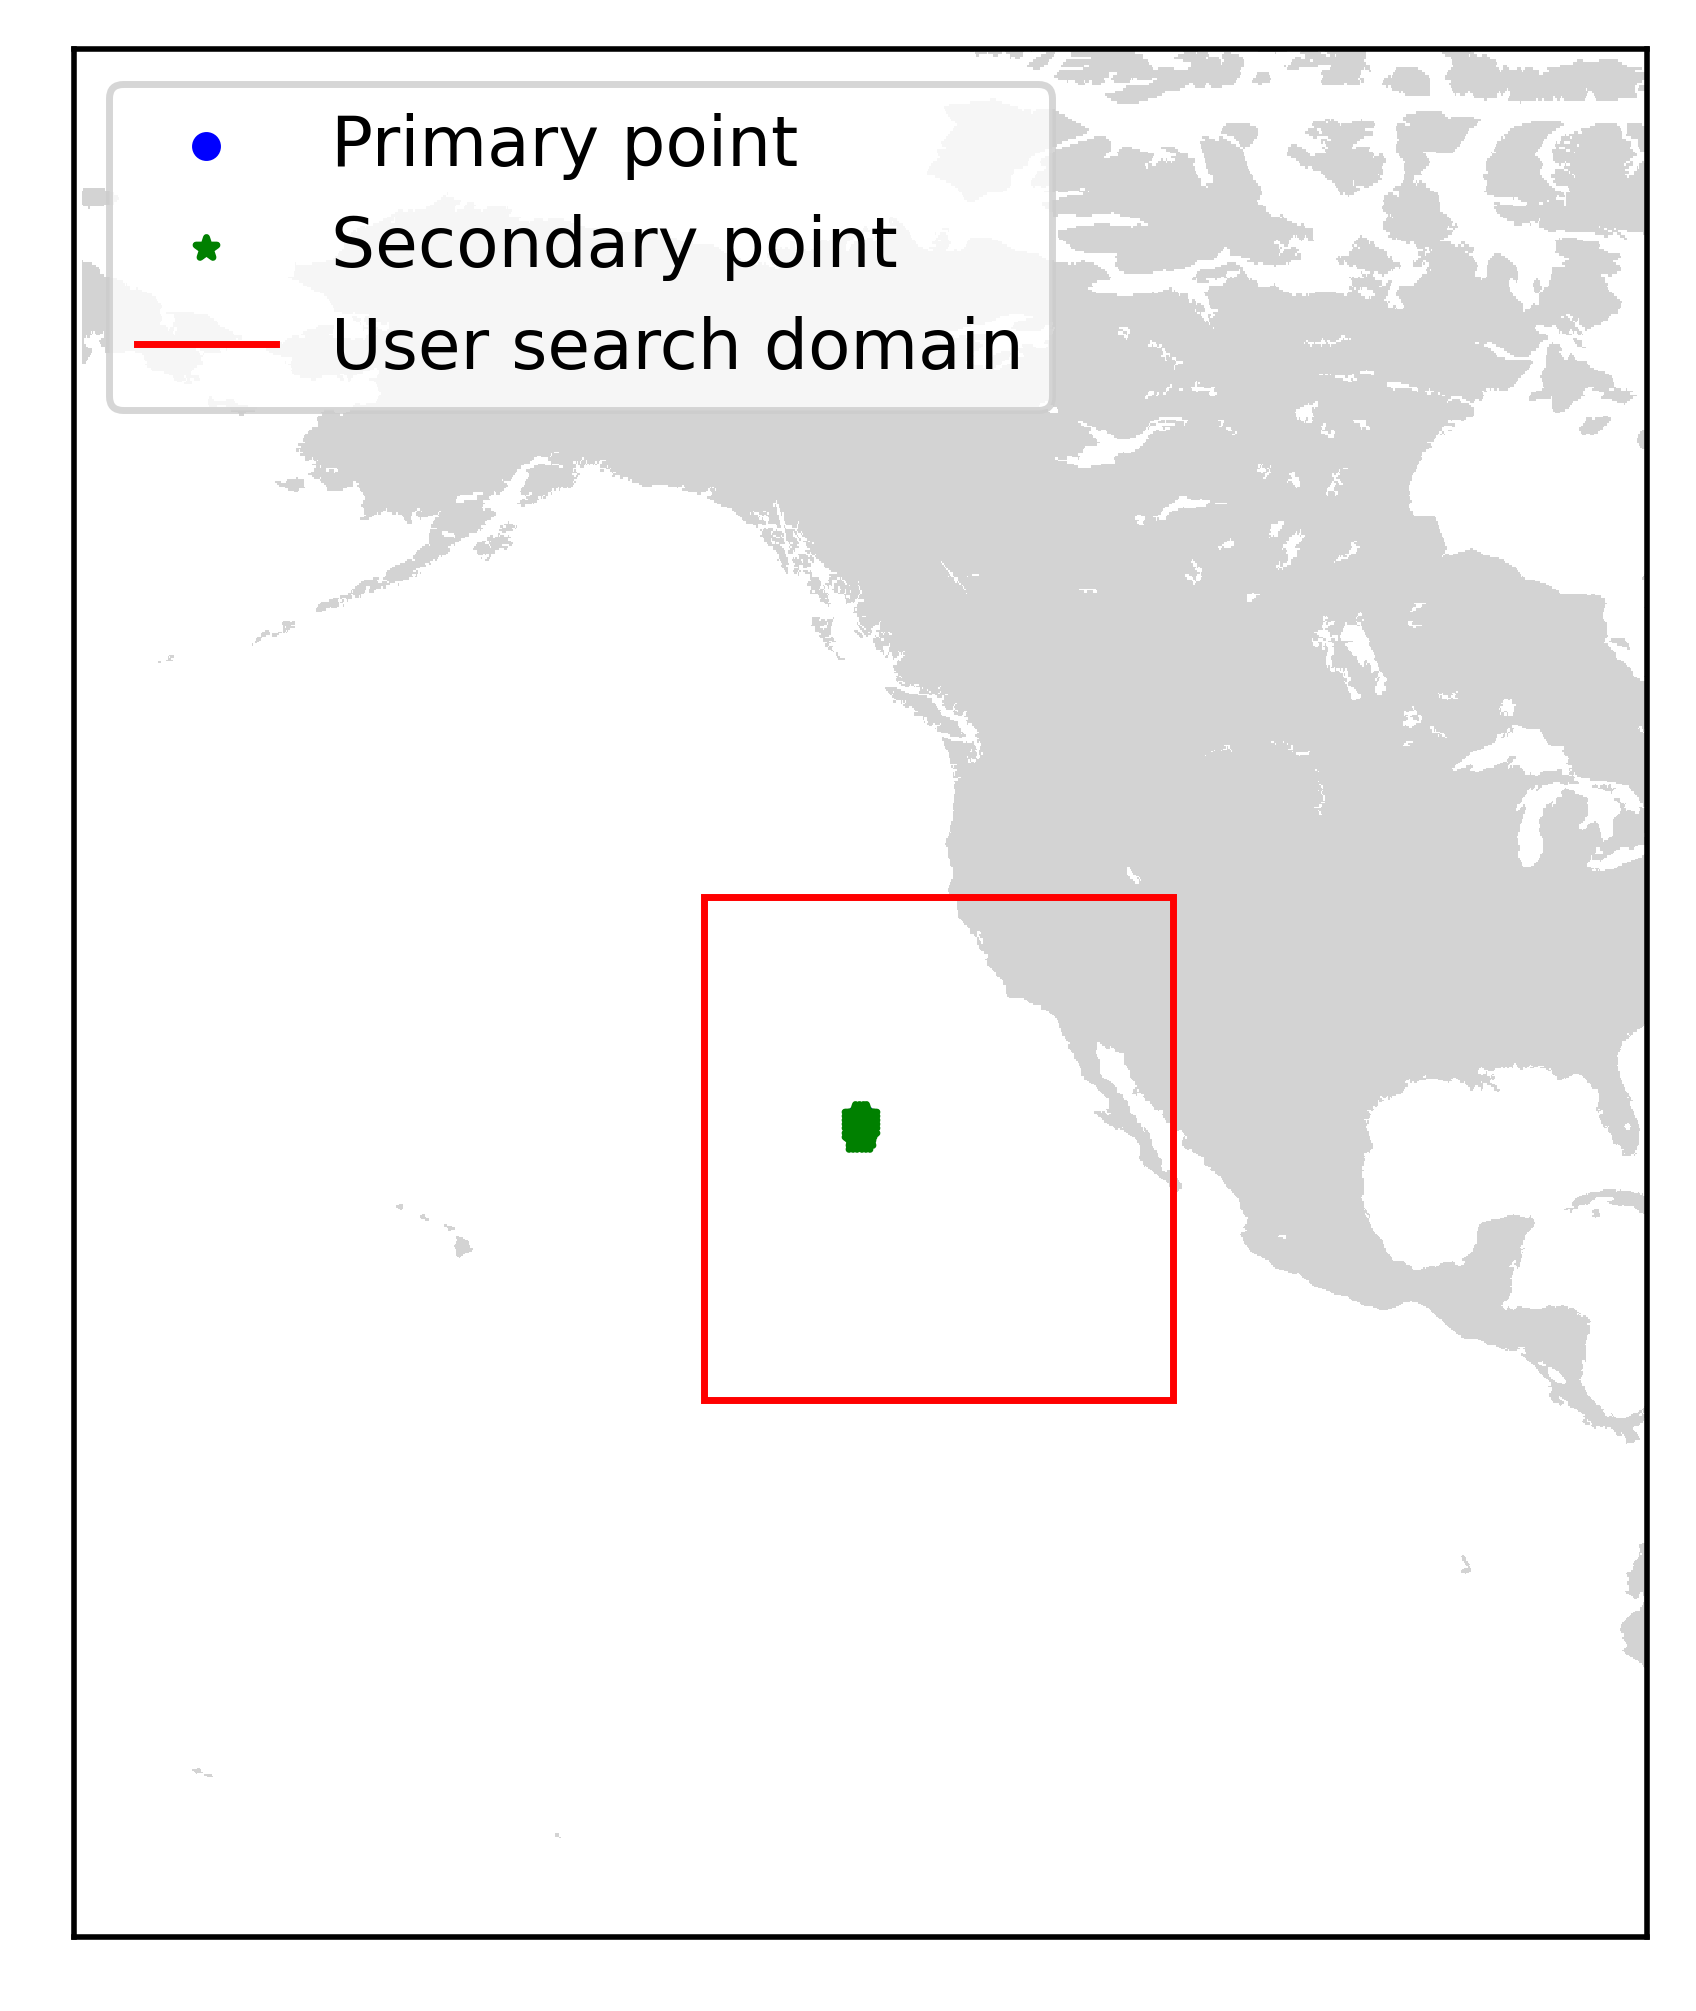

In [13]:
plot_points(primary_points, secondary_points)

In [14]:
def generate_diff_plot(primary_points, secondary_points, primary_name, secondary_name, units):
    diffs = [primary_point[2] - secondary_point[2] for primary_point, secondary_point in zip(primary_points, secondary_points)]
    
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min([point[0] for point in primary_points])
    max_lon = max([point[0] for point in primary_points])
    min_lat = min([point[1] for point in primary_points])
    max_lat = min([point[1] for point in primary_points])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 10,
        urcrnrlat=max_lat + 10,
        llcrnrlon=min_lon - 10,
        urcrnrlon=max_lon + 10
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap([point[0] for point in secondary_points], [point[1] for point in secondary_points])
    
    # Customize colormap/colorbar
    cmap = plt.cm.coolwarm
    # Draw scatter points
    sc = plt.scatter(x2, y2, 30, marker='o', c=diffs, alpha=0.7, cmap=cmap)

    cb = plt.colorbar(sc)
    cb.ax.set_title(units,fontsize=8)        
    plt.title(f'Difference plot between {primary_name} and {secondary_name}')

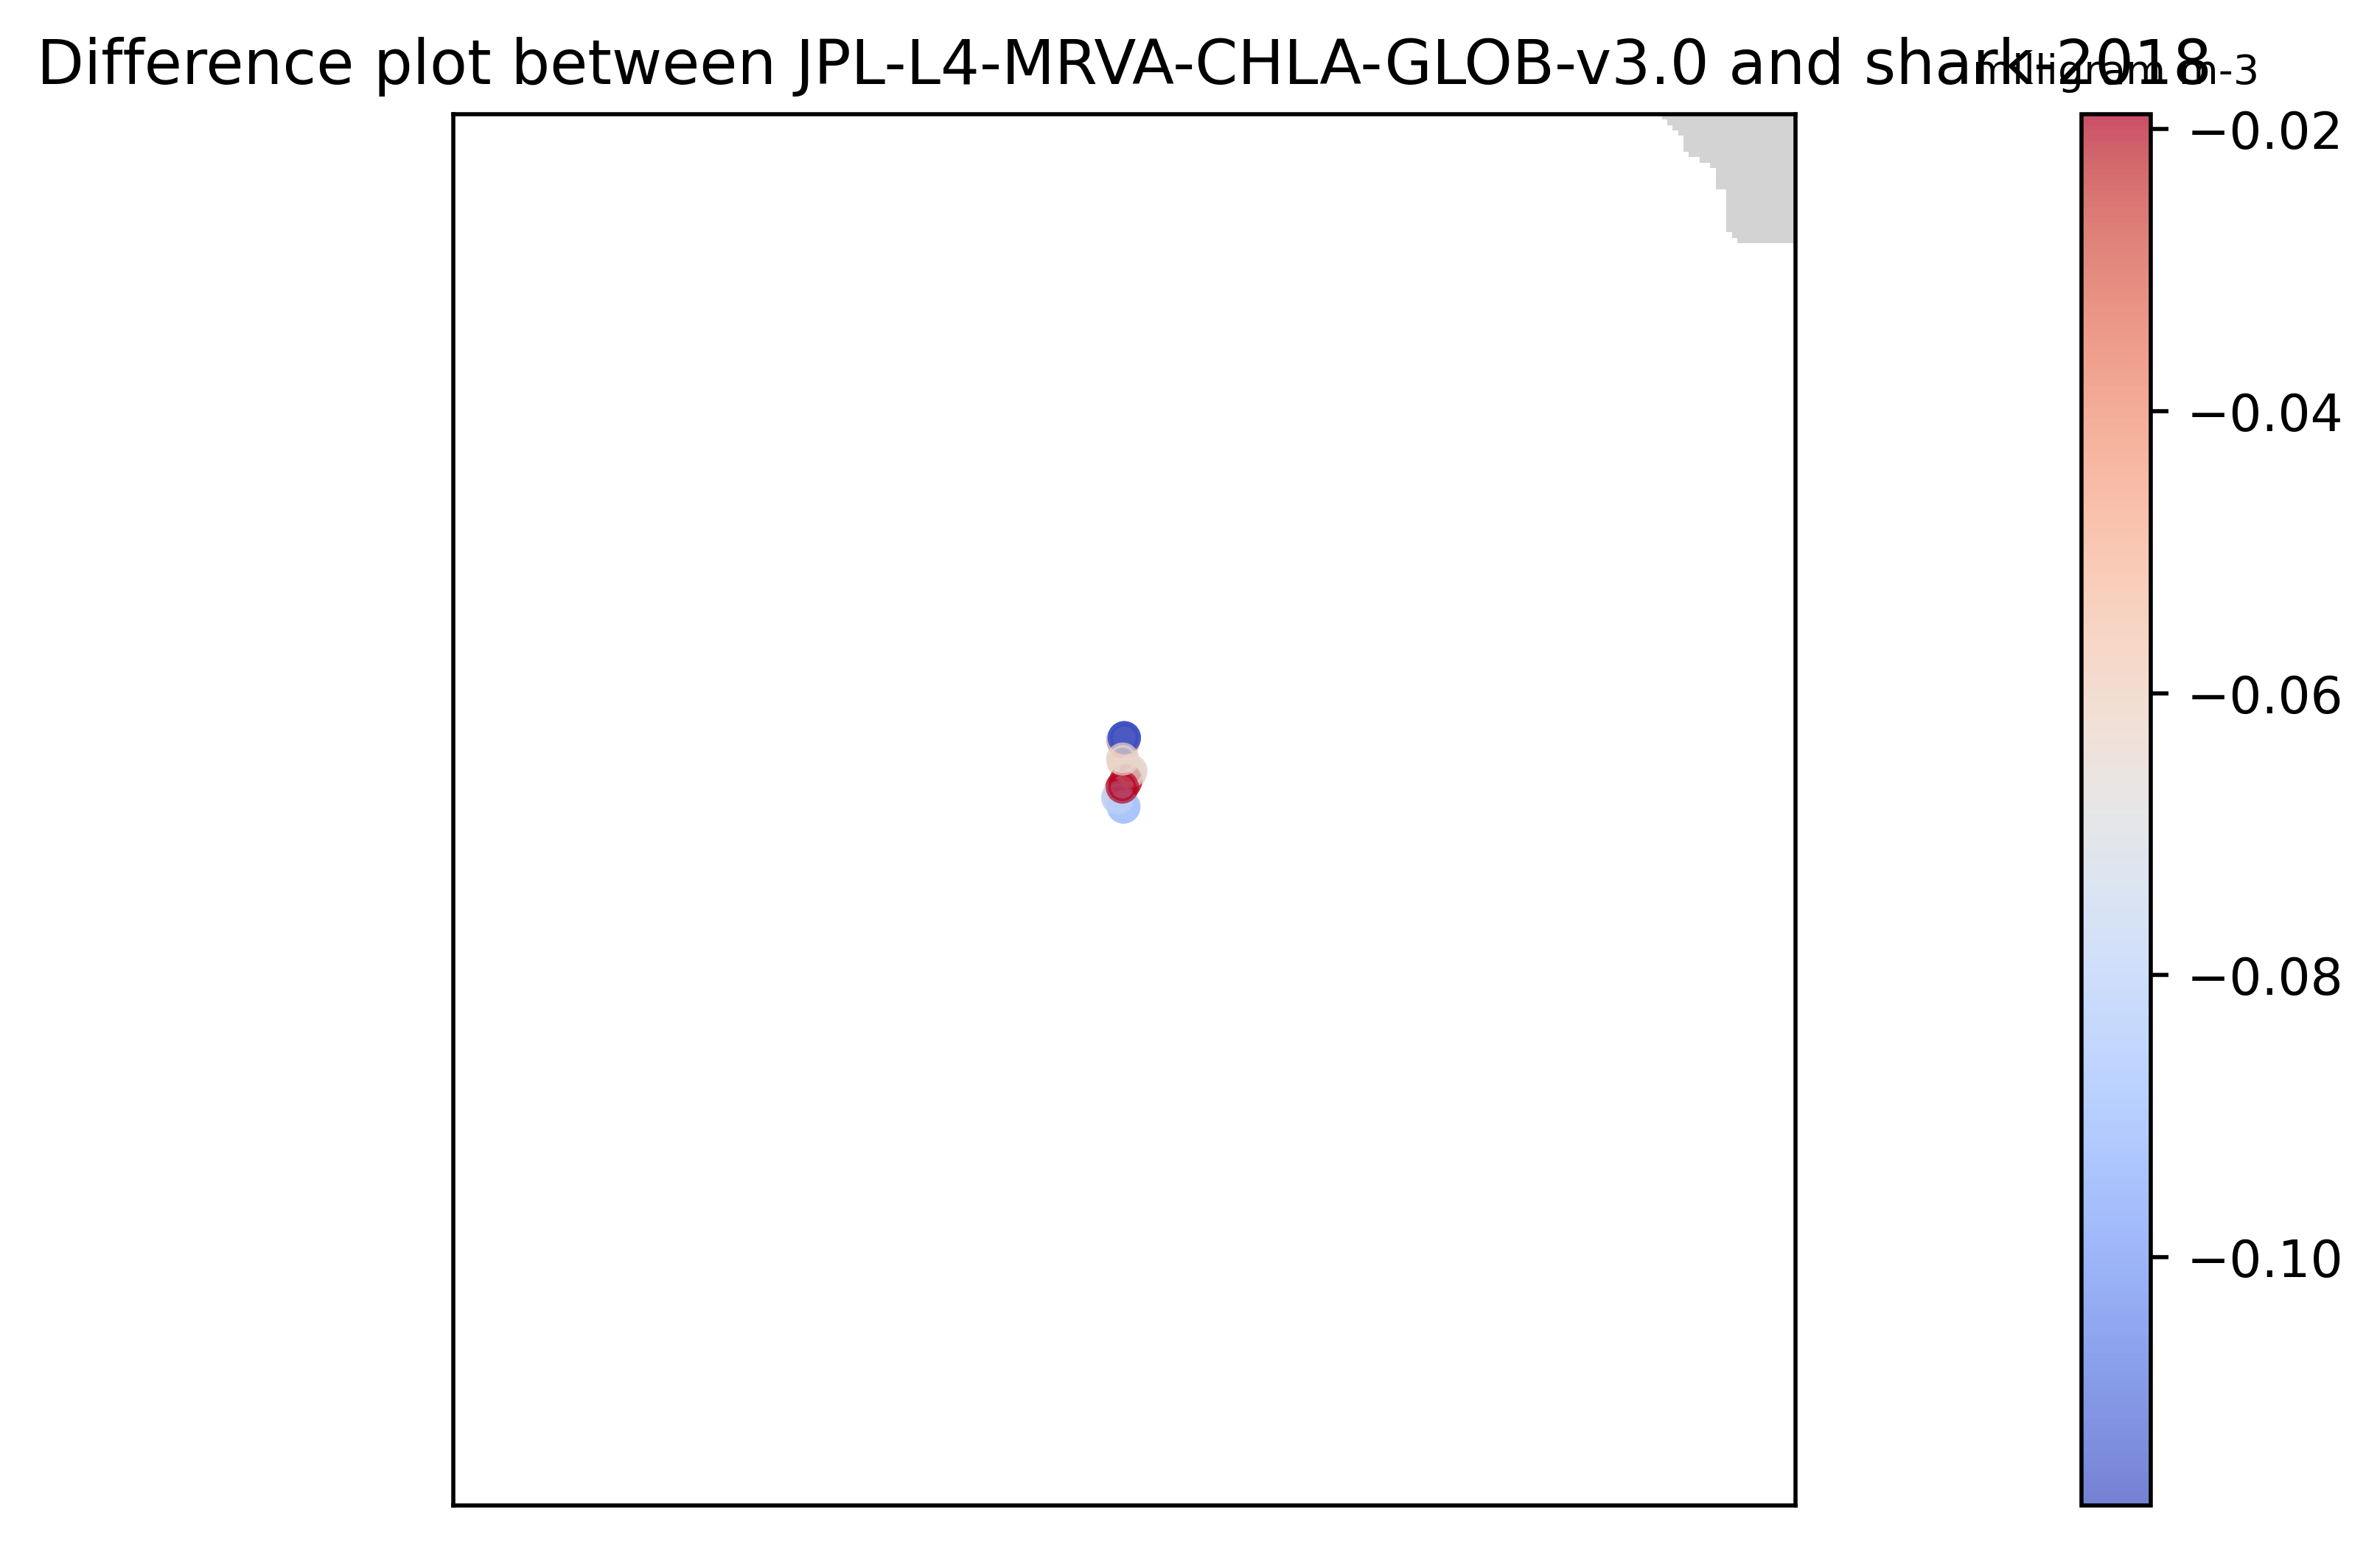

In [15]:
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], 'milligram m-3')

### Run satellite to in situ matchup query

Match MUR25-JPL-L4-GLOB-v04.2 with ICOADS Release 3.0

In [16]:
query_params = {
    'primary': 'MUR25-JPL-L4-GLOB-v04.2',
    'secondary': 'ICOADS_JPL',
    'startTime': '2018-04-01T00:00:00Z',
    'endTime': '2018-04-01T23:59:59Z',
    'tt': 86400,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-140,10,-110,40',
    'platforms': '42',
    'parameter': 'sea_water_temperature',
    'depthMin': -5,
    'depthMax': 5,
    'matchOnce': 'true',
    'resultSizeLimit': 0
}

primary_points, secondary_points, execution_id = execute_matchup_request(query_params, query_params['parameter'])

https://doms.jpl.nasa.gov/match_spark?primary=MUR25-JPL-L4-GLOB-v04.2&secondary=ICOADS_JPL&startTime=2018-04-01T00%3A00%3A00Z&endTime=2018-04-01T23%3A59%3A59Z&tt=86400&rt=50000&b=-140%2C10%2C-110%2C40&platforms=42&parameter=sea_water_temperature&depthMin=-5&depthMax=5&matchOnce=true&resultSizeLimit=0
Total number of primary matched points 698
Total number of secondary matched points 698


In [17]:
def fetch_result(execution_id, output_format, output_file, primary_variable, secondary_variable):
    match_up_results_csv = f'{output_file}.csv'
    response = requests.get("https://doms.jpl.nasa.gov/domsresults", params={"id": execution_id, "output": output_format})
    with open(output_file, mode='wb') as f:
        f.write(response.content)

    matches = cdms_reader.assemble_matches(output_file)

    cdms_reader.matches_to_csv(matches, match_up_results_csv)
    
    columns_to_include = ["PrimaryData_lon", "PrimaryData_lat", "PrimaryData_datetime", "SecondaryData_lon", "SecondaryData_lat", "SecondaryData_datetime"]
    for variable in primary_variable:
        columns_to_include.append(f'PrimaryData_{variable}')
    for variable in secondary_variable:
        columns_to_include.append(f'SecondaryData_{variable}')
    return pd.read_csv(match_up_results_csv, usecols=columns_to_include)

In [18]:
df = fetch_result(execution_id, "NETCDF", "mur_to_icoads_results.nc", ["sea_surface_foundation_temperature"], ["sea_water_temperature"])
df

/Users/nchung/PycharmProjects/cdms-notebooks/cdms_reader.py:71: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  match_dict[group][var] = cdms_nc.groups[group][var][ID]
/Users/nchung/PycharmProjects/cdms-notebooks/cdms_reader.py:71: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  match_dict[group][var] = cdms_nc.groups[group][var][ID]


,PrimaryData_lon,PrimaryData_lat,PrimaryData_sea_surface_foundation_temperature,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_sea_water_temperature,SecondaryData_datetime
0,-113.375,10.375,28.484985,2018-04-01 08:59:44,-113.35,10.74,28.28,2018-04-02 08:29:52
1,-122.375,23.875,20.316986,2018-04-01 08:59:44,-122.23,23.53,21.04,2018-03-31 09:59:28
2,-133.125,10.875,26.928009,2018-04-01 08:59:44,-132.75,11.01,27.10,2018-04-02 08:59:44
3,-115.625,12.625,27.964996,2018-04-01 08:59:44,-116.03,12.45,27.37,2018-03-31 08:59:44
4,-135.625,12.375,26.536987,2018-04-01 08:59:44,-135.67,12.16,26.72,2018-04-01 07:00:16
...,...,...,...,...,...,...,...,...
693,-137.875,13.875,25.816986,2018-04-01 08:59:44,-137.99,14.30,25.44,2018-04-01 18:01:36
694,-132.875,19.125,23.764008,2018-04-01 08:59:44,-132.45,19.22,23.58,2018-04-02 06:04:48
695,-126.875,31.625,16.321014,2018-04-01 08:59:44,-126.36,31.61,16.65,2018-03-31 09:18:56
696,-124.375,20.375,23.214996,2018-04-01 08:59:44,-124.36,20.57,22.82,2018-03-31 08:59:44


In [19]:
def generate_scatter_plot(primary_points, secondary_points, primary_name, secondary_name, variable_name, units):
    x = np.array([point[2] for point in secondary_points])
    y = np.array([point[2] for point in primary_points])
    m, b = np.polyfit(x, y, 1)
    fig, ax = plt.subplots()
    ax.set_title(f'{variable_name} scatter\n{primary_name} vs. {secondary_name}')
    ax.set_xlabel("%s %s" % (secondary_name, units))
    ax.set_ylabel("%s %s" % (primary_name, units))
    ax.scatter(x, y)
    ax.plot(x, m*x+b);
    ax.plot([0,1],[0,1], transform=ax.transAxes)

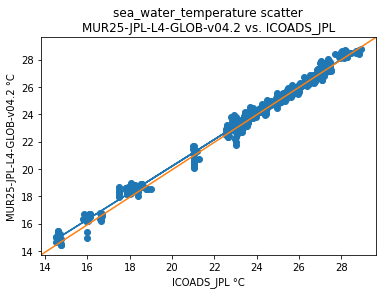

In [20]:
generate_scatter_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], query_params['parameter'], '°C')

### Run satellite to in situ matchup query

Match ASCATB-L2-Coastal with SAMOS


In [21]:
query_params = {
    'primary': 'ASCATB-L2-Coastal',
    'secondary': 'SAMOS',
    'startTime': '2017-05-01T00:00:00Z',
    'endTime': '2017-05-04T23:59:59Z',
    'tt': 43200,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-100,20,-90,30',
    'platforms': '30',
    'parameter': 'wind_speed',
    'depthMin': -10,
    'depthMax': 10,
    'matchOnce': 'true',
    'resultSizeLimit': 0
}

primary_points, secondary_points, execution_id = execute_matchup_request(query_params, query_params["parameter"])

https://doms.jpl.nasa.gov/match_spark?primary=ASCATB-L2-Coastal&secondary=SAMOS&startTime=2017-05-01T00%3A00%3A00Z&endTime=2017-05-04T23%3A59%3A59Z&tt=43200&rt=50000&b=-100%2C20%2C-90%2C30&platforms=30&parameter=wind_speed&depthMin=-10&depthMax=10&matchOnce=true&resultSizeLimit=0
Total number of primary matched points 171
Total number of secondary matched points 171


In [22]:
df = fetch_result(execution_id, "NETCDF", "ascat_to_samos_results.nc", [query_params["parameter"]], [query_params["parameter"], "depth"])
df

/Users/nchung/PycharmProjects/cdms-notebooks/cdms_reader.py:71: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  match_dict[group][var] = cdms_nc.groups[group][var][ID]
/Users/nchung/PycharmProjects/cdms-notebooks/cdms_reader.py:71: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  match_dict[group][var] = cdms_nc.groups[group][var][ID]


,PrimaryData_lon,PrimaryData_lat,PrimaryData_wind_speed,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_depth,SecondaryData_wind_speed,SecondaryData_datetime
0,-93.40308,27.77886,10.62,2017-05-03 15:40:48,-93.3018,27.8766,-99999.0,8.3,2017-05-03 18:20:48
1,-92.91428,27.82262,8.29,2017-05-04 02:54:56,-93.2733,27.8674,-99999.0,7.2,2017-05-03 22:19:44
2,-93.60022,28.39571,1.32,2017-05-01 16:21:20,-93.7307,28.6263,-99999.0,10.7,2017-05-02 04:20:16
3,-93.27585,27.75776,10.67,2017-05-03 15:40:48,-93.1843,27.9276,-99999.0,7.7,2017-05-03 04:22:24
4,-93.27585,27.75776,10.67,2017-05-03 15:40:48,-93.2736,27.8663,-99999.0,7.2,2017-05-03 22:17:36
...,...,...,...,...,...,...,...,...,...
166,-93.46637,28.12207,10.55,2017-05-03 15:40:48,-93.2592,28.1035,-99999.0,7.1,2017-05-04 00:00:00
167,-93.56415,28.50581,1.20,2017-05-01 16:21:20,-93.7307,28.6263,-99999.0,10.7,2017-05-02 04:20:16
168,-93.61801,28.75897,0.68,2017-05-01 16:21:20,-93.7690,28.6973,-99999.0,10.9,2017-05-02 03:56:48
169,-92.82217,28.32290,6.87,2017-05-04 02:54:56,-93.2592,28.1035,-99999.0,7.1,2017-05-04 00:00:00


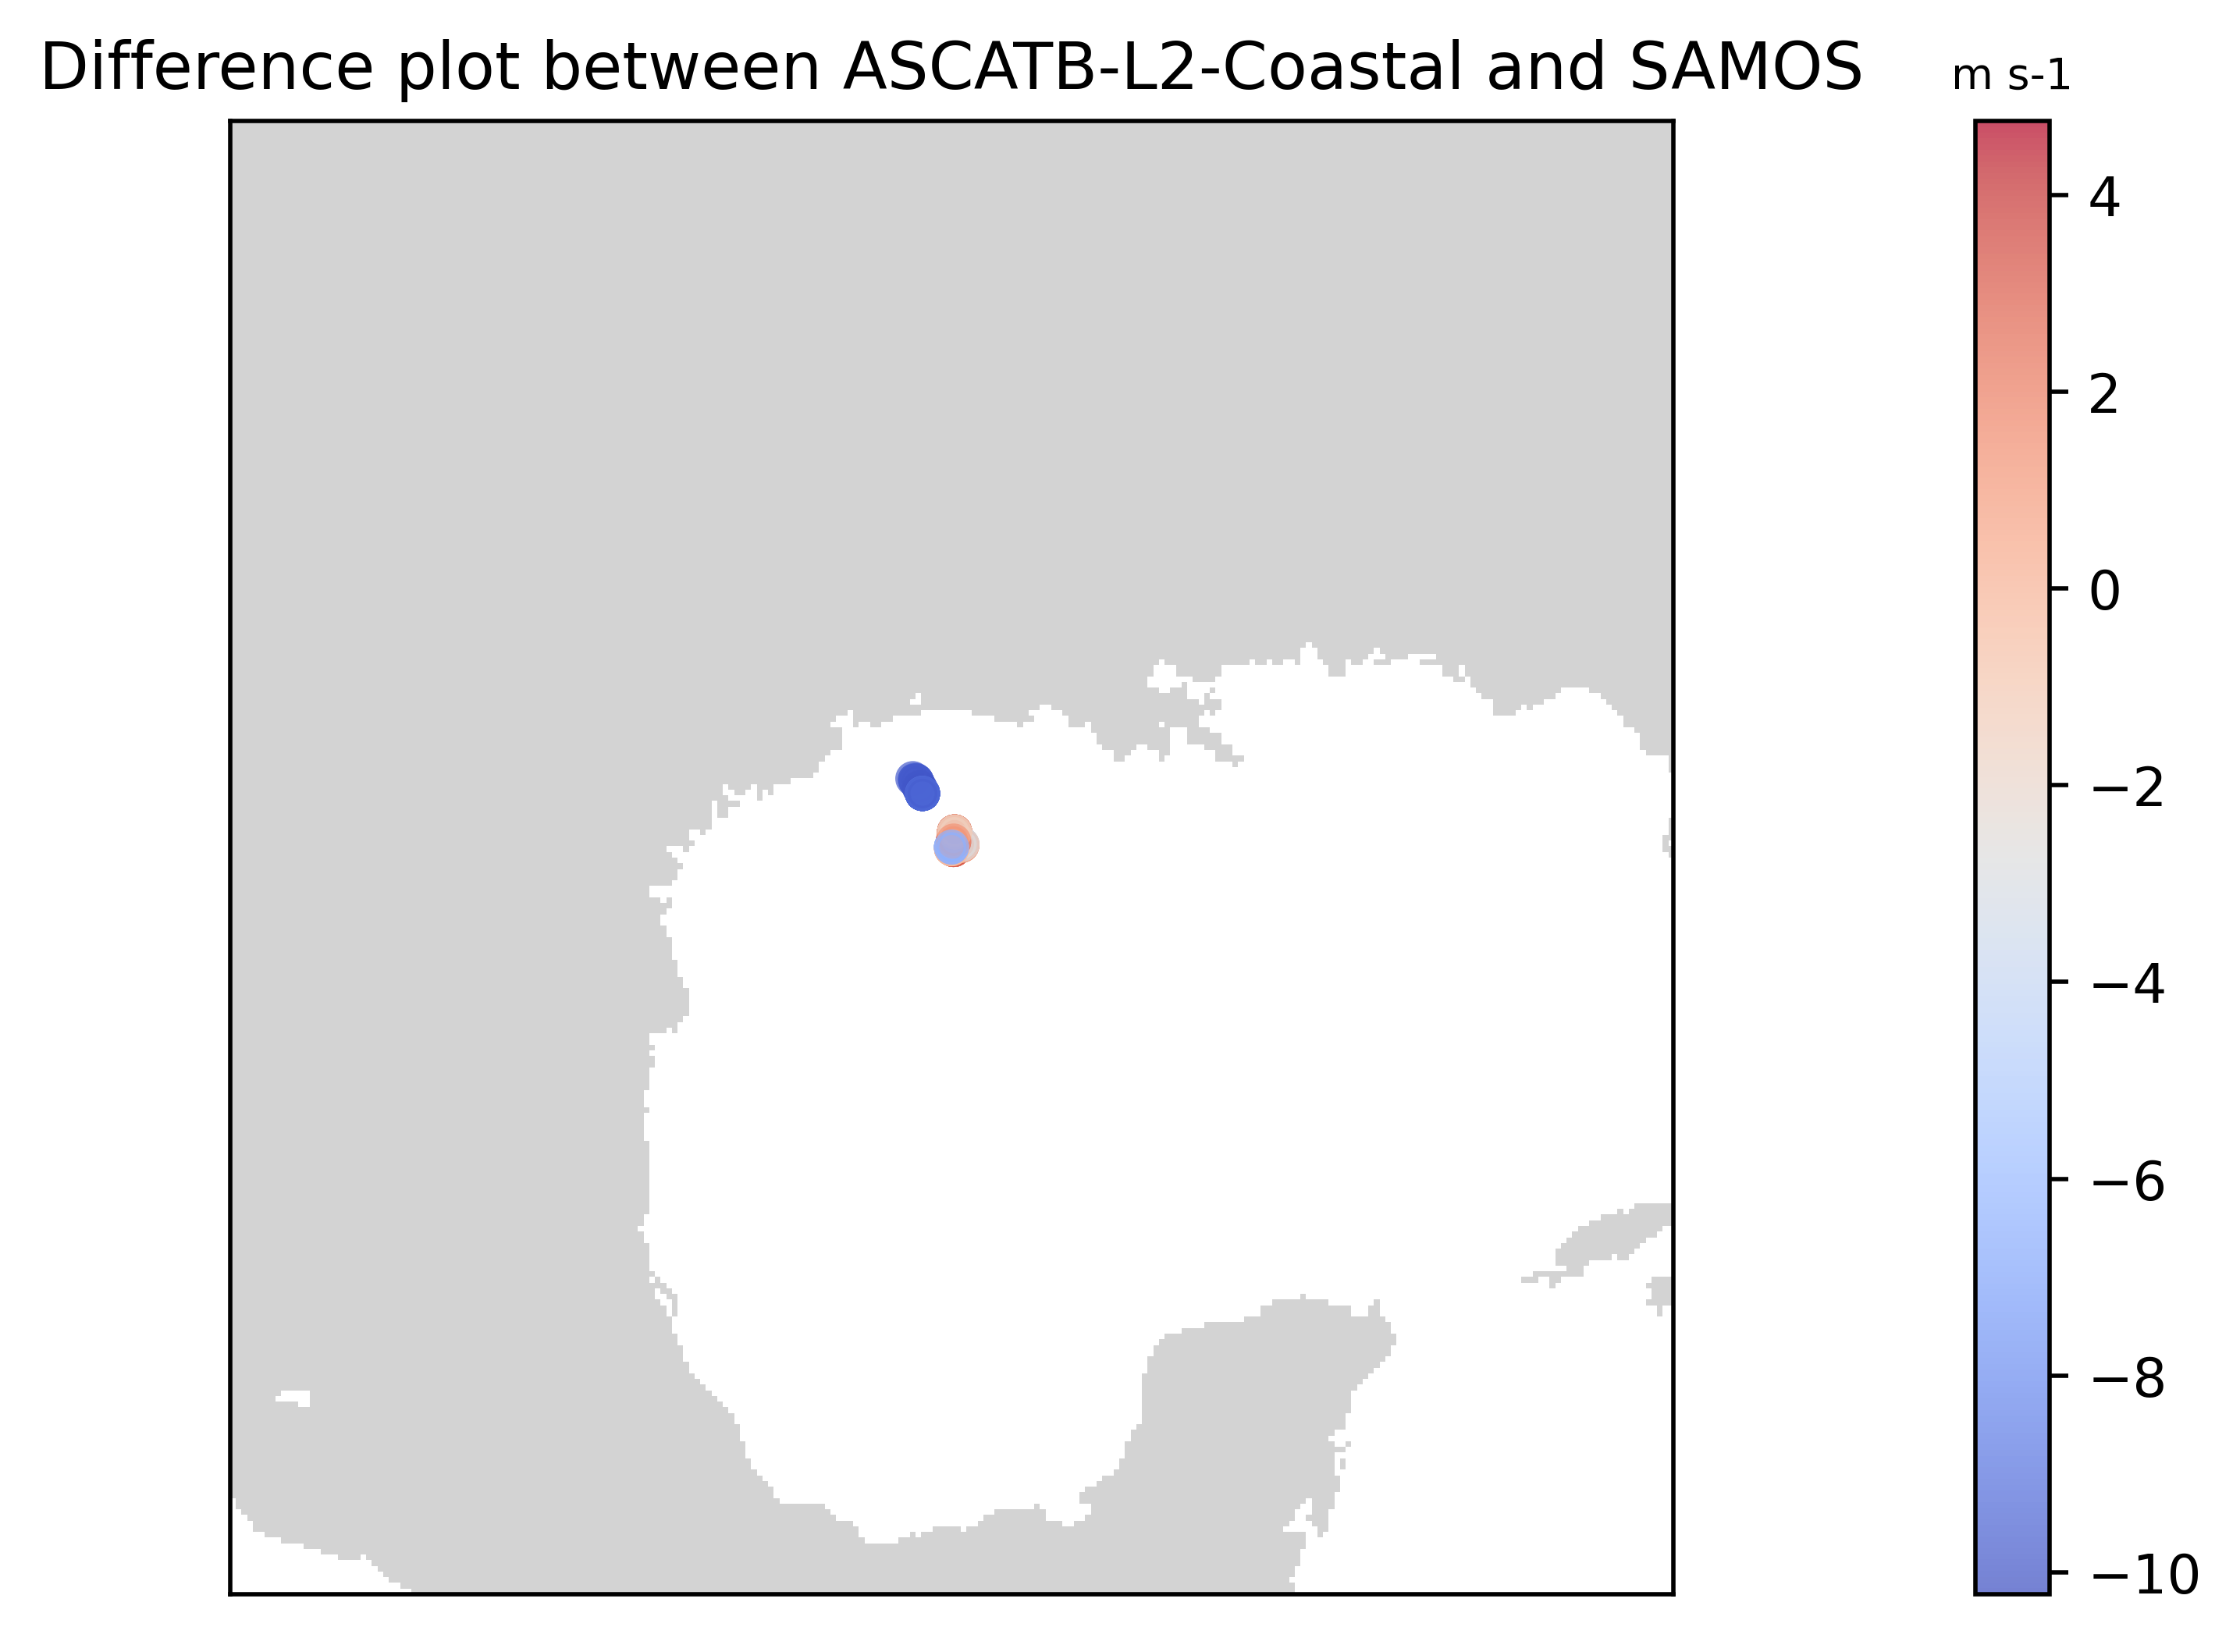

In [23]:
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], 'm s-1')

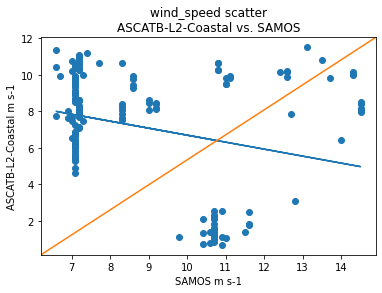

In [24]:
generate_scatter_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], query_params['parameter'], 'm s-1')

### Run satellite to satellite matchup query
Match SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5 with OISSS_L4_multimission_7day_v1

In [25]:
query_params = {
    'primary': 'SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5',
    'secondary': 'OISSS_L4_multimission_7day_v1',
    'startTime': '2018-08-01T00:00:00Z',
    'endTime': '2018-08-02T00:00:00Z',
    'tt': 604800,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-100,20,-90,30',
    'platforms': '65',
    'parameter': 'sea_surface_salinity',
    'depthMin': -20,
    'depthMax': 10,
    'matchOnce': 'true',
    'resultSizeLimit': 0
}

primary_points, secondary_points, execution_id = execute_matchup_request(query_params)

https://doms.jpl.nasa.gov/match_spark?primary=SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5&secondary=OISSS_L4_multimission_7day_v1&startTime=2018-08-01T00%3A00%3A00Z&endTime=2018-08-02T00%3A00%3A00Z&tt=604800&rt=50000&b=-100%2C20%2C-90%2C30&platforms=65&parameter=sea_surface_salinity&depthMin=-20&depthMax=10&matchOnce=true&resultSizeLimit=0
Total number of primary matched points 1058
Total number of secondary matched points 1058


In [26]:
df = fetch_result(execution_id, "NETCDF", "smap_sss_to_oisss_results.nc", [query_params['parameter']], [query_params['parameter']])
df

,PrimaryData_lon,PrimaryData_lat,PrimaryData_sea_surface_salinity,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_sea_surface_salinity,SecondaryData_datetime
0,-97.625,22.625,36.795270,2018-08-01 12:01:04,-97.375,22.625,36.490902,2018-08-03 00:00:00
1,-94.375,20.875,36.740223,2018-08-01 12:01:04,-94.375,20.875,36.574770,2018-08-03 00:00:00
2,-94.375,29.125,36.463905,2018-08-01 12:01:04,-94.375,29.125,35.687496,2018-08-03 00:00:00
3,-96.125,23.125,36.560787,2018-08-01 12:01:04,-96.125,23.125,36.506294,2018-08-03 00:00:00
4,-92.625,24.625,36.244946,2018-08-01 12:01:04,-92.625,24.625,36.159958,2018-08-03 00:00:00
...,...,...,...,...,...,...,...,...
1053,-96.125,24.125,36.524075,2018-08-01 12:01:04,-96.125,24.125,36.486195,2018-08-03 00:00:00
1054,-93.625,26.125,36.654823,2018-08-01 12:01:04,-93.625,26.125,36.328884,2018-08-03 00:00:00
1055,-92.375,24.125,35.596890,2018-08-01 12:01:04,-92.375,24.125,36.098870,2018-08-03 00:00:00
1056,-96.375,24.125,36.348820,2018-08-01 12:01:04,-96.375,24.125,36.449210,2018-08-03 00:00:00


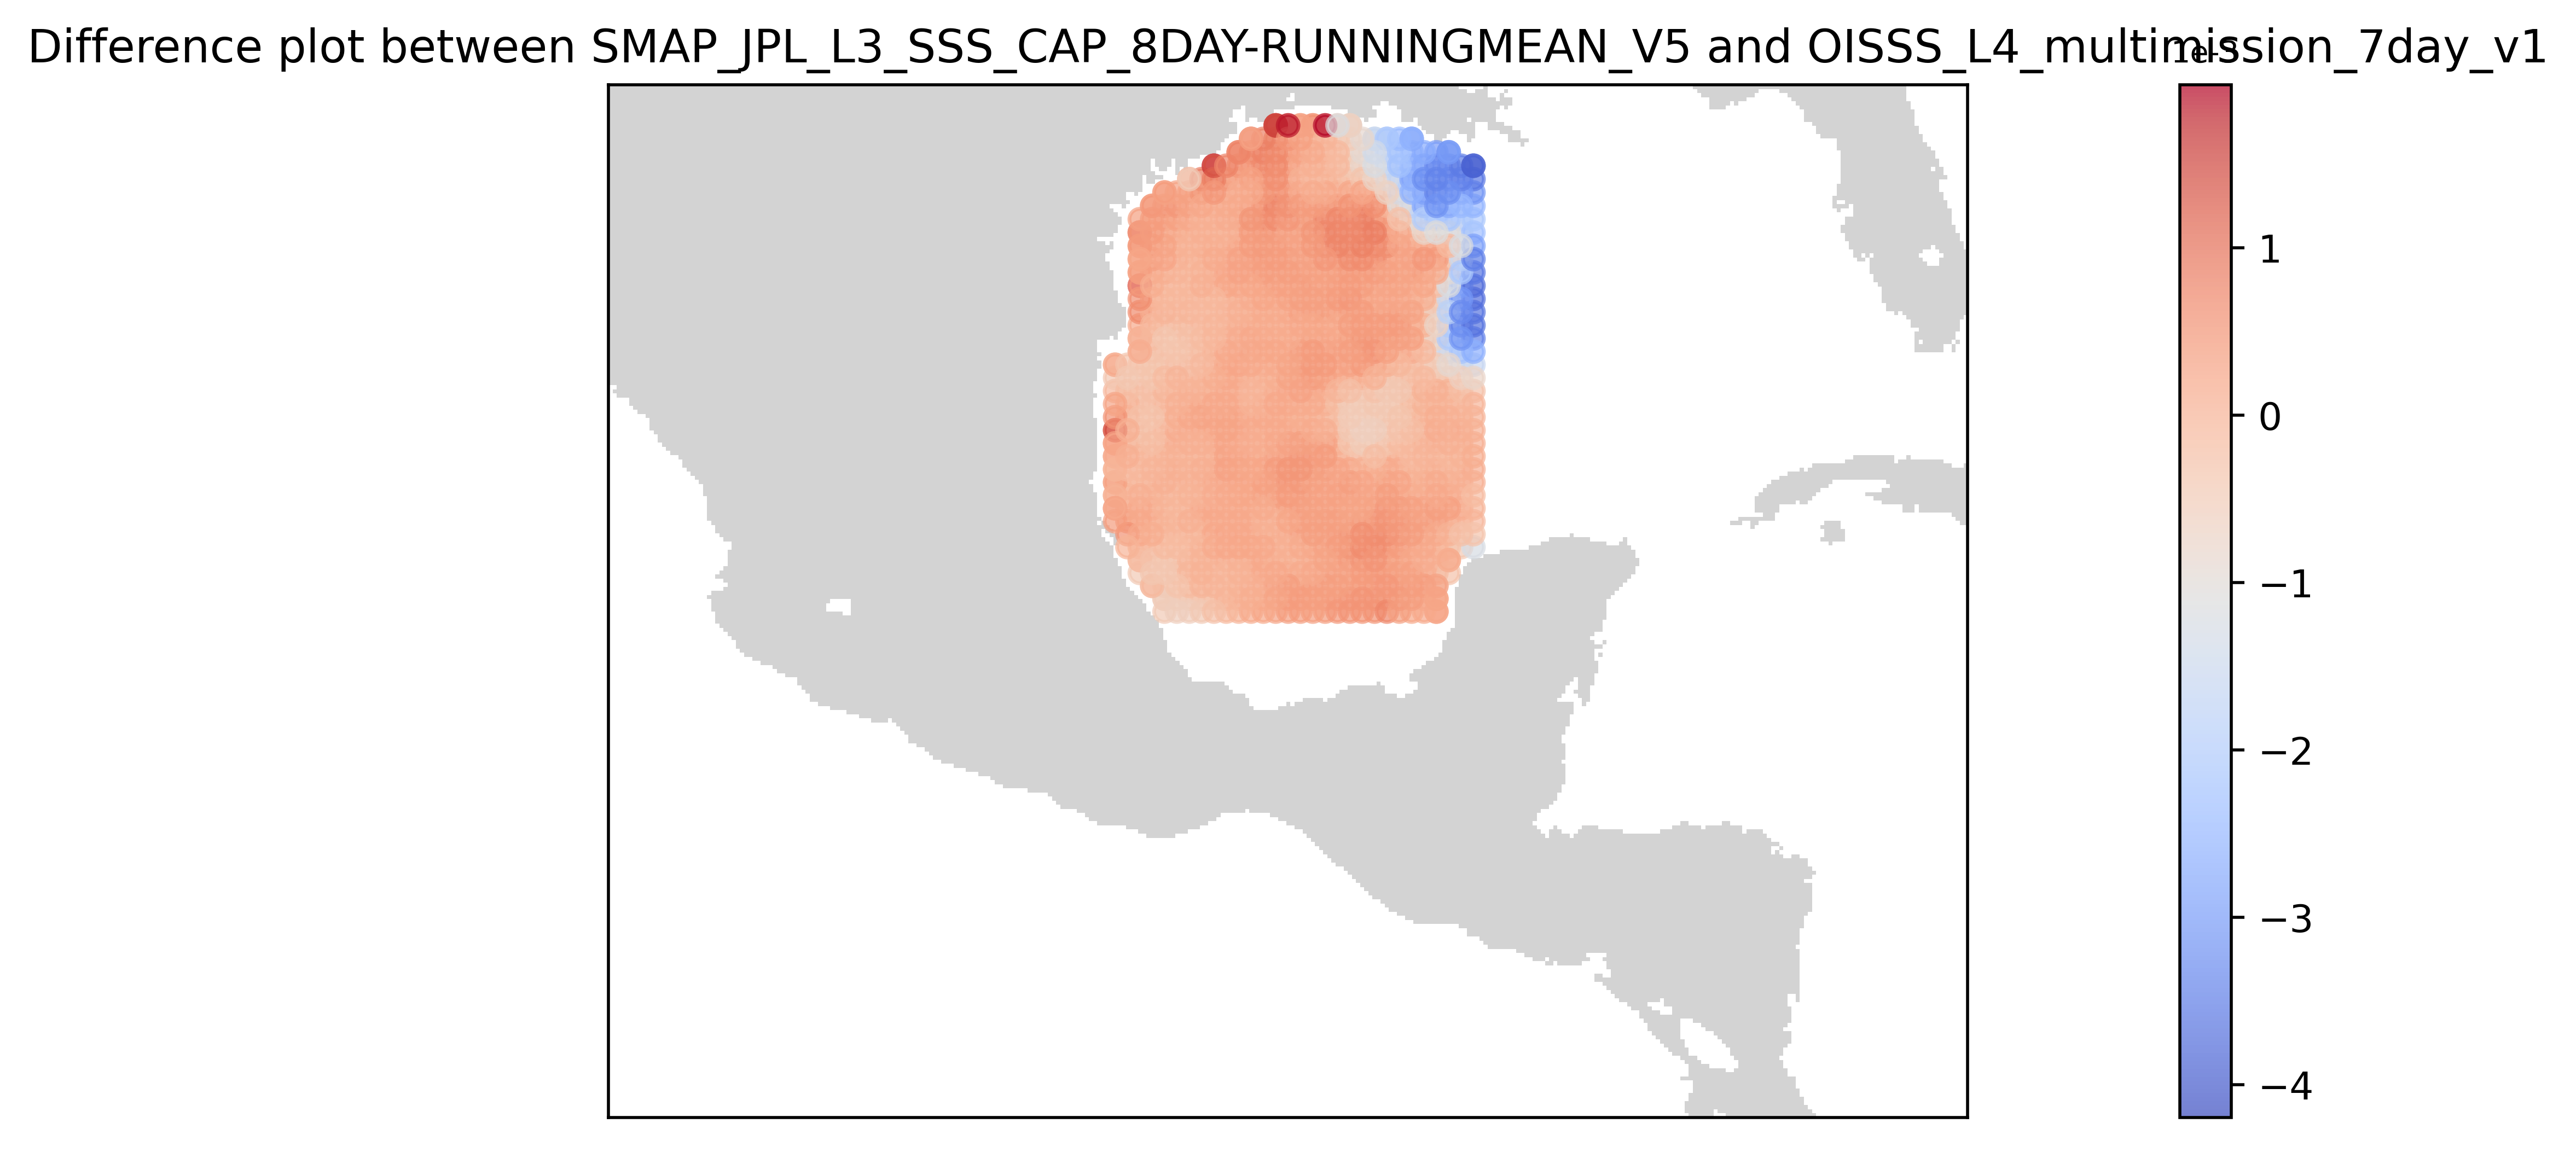

In [27]:
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], '1e-3')

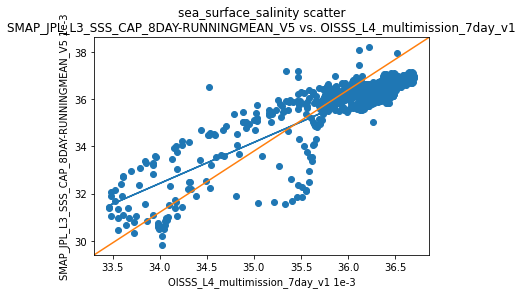

In [28]:
generate_scatter_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], query_params['parameter'], '1e-3')

### Run satellite to satellite matchup query

Match ASCATB-L2-Coastal with MUR25-JPL-L4-GLOB-v04.2

In [29]:
query_params = {
    'primary': 'ASCATB-L2-Coastal',
    'secondary': 'MUR25-JPL-L4-GLOB-v04.2',
    'startTime': '2018-08-01T00:00:00Z',
    'endTime': '2018-08-02T00:00:00Z',
    'tt': 43200,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-100,20,-90,30',
    'platforms': '65',
    'depthMin': -20,
    'depthMax': 10,
    'matchOnce': 'true',
    'resultSizeLimit': 0
}

primary_points, secondary_points, execution_id = execute_matchup_request(query_params)

https://doms.jpl.nasa.gov/match_spark?primary=ASCATB-L2-Coastal&secondary=MUR25-JPL-L4-GLOB-v04.2&startTime=2018-08-01T00%3A00%3A00Z&endTime=2018-08-02T00%3A00%3A00Z&tt=43200&rt=50000&b=-100%2C20%2C-90%2C30&platforms=65&depthMin=-20&depthMax=10&matchOnce=true&resultSizeLimit=0
Total number of primary matched points 5527
Total number of secondary matched points 5527


In [31]:
df = fetch_result(execution_id, "NETCDF", "ascat_l2_to_mur_l4_results.nc", ["wind_speed", "wind_to_direction"], ["sea_surface_foundation_temperature"])
df

/Users/nchung/PycharmProjects/cdms-notebooks/cdms_reader.py:71: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  match_dict[group][var] = cdms_nc.groups[group][var][ID]
/Users/nchung/PycharmProjects/cdms-notebooks/cdms_reader.py:71: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  match_dict[group][var] = cdms_nc.groups[group][var][ID]


,PrimaryData_lon,PrimaryData_lat,PrimaryData_wind_speed,PrimaryData_wind_to_direction,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_sea_surface_foundation_temperature,SecondaryData_datetime
0,-93.91797,25.51929,3.43,314.500000,2018-08-01 02:57:04,-93.875,25.625,31.075989,2018-08-01 08:59:44
1,-90.29779,25.41223,7.70,23.300001,2018-08-01 15:23:44,-90.375,25.375,30.101990,2018-08-01 08:59:44
2,-90.01508,22.04596,7.09,336.200000,2018-08-01 15:23:44,-90.125,22.125,30.386993,2018-08-01 08:59:44
3,-95.46347,28.16772,1.82,253.800000,2018-08-01 02:59:12,-95.375,28.125,29.602997,2018-08-01 08:59:44
4,-91.42578,22.98813,7.27,352.100000,2018-08-01 15:23:44,-91.375,22.875,30.786010,2018-08-01 08:59:44
...,...,...,...,...,...,...,...,...,...
5522,-90.15598,26.07202,6.07,356.900000,2018-08-01 15:23:44,-90.125,26.125,30.139008,2018-08-01 08:59:44
5523,-93.73560,28.99400,1.45,261.600000,2018-08-01 02:59:12,-93.625,28.875,30.040985,2018-08-01 08:59:44
5524,-91.83453,24.64548,4.52,1.900000,2018-08-01 02:57:04,-91.875,24.625,30.548004,2018-08-01 08:59:44
5525,-90.62851,26.26532,9.45,310.000000,2018-08-01 15:23:44,-90.625,26.375,29.903992,2018-08-01 08:59:44
